In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import load_boston

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

import warnings

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [5]:
names=modelSeason18['CorsicaID']
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [6]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [7]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18=modelSeason18.reset_index(drop=True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

y=modelSeason18['Cap Hit']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [8]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

y=modelSeason18['Cap Hit']

In [9]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=modelSeason18['Cap Hit']
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 11, 12, 15, 19, 33, 36, 38, 39, 43, 44, 48, 88, 107, 109, 111, 113, 114, 117, 118, 126, 129, 131, 136, 138, 144]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [11]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90793410953.8125, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103248497004.9375, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

Best alpha using built-in LassoCV: 26.439667
Best score using built-in LassoCV: 0.551511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74270631347.1875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78405047985.875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76529430756.25, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to 

In [12]:
def bs(model,xVal,yVal):
    n_iterations = 1000
    n_size = int(len(xVal)*.8)
    # run bootstrap
    stats  = list()
    val_residuals = list()
    for i in range(n_iterations):
        # prepare train and test sets
        samp=resample(range(0,len(xVal)-1), n_samples=n_size)
        xtrain = xVal.loc[samp,:]
        xtest = xVal.loc[set(range(0,len(xVal)-1))-set(samp),:]
        ytrain = yVal.loc[samp]
        ytest = yVal.loc[set(range(0,len(xVal)-1))-set(samp)]
        xtrain=xtrain.reset_index(drop=True)
        xtest=xtest.reset_index(drop=True)
        ytrain=ytrain.reset_index(drop=True)
        ytest=ytest.reset_index(drop=True)
        
        # fit model
        #model = DecisionTreeClassifier()
        model.fit(xtrain, ytrain)
        # evaluate model
        predictions = model.predict(xtest)
        #print( [i ** 2 for i in (ytest - predictions)])
        #print((ytest - predictions)^2)
        #print([sum((j ** 2))/(len(xtest)-2) for j in (ytest - predictions)])
        val_residuals.append(np.std(model.predict(X_test)))
        score = model.score(xtest, ytest)
        stats.append(score)
        #bootstrap_preds[i] = predictions
    
    #bootstrap_preds -= np.mean(bootstrap_preds)
    #val_residuals = np.concatenate(val_residuals)
    
    #fix######################################################################
    plt.scatter(y_test,model.predict(X_test))
    plt.show()
    
    val_residuals=pd.DataFrame(list(val_residuals),columns=['Residual'])
    print(val_residuals.head())
    
    val_residuals.sort_values(by=['Residual'],inplace=True)
    val_residuals=val_residuals.reset_index(drop=True)
    print(int(n_iterations*.05))
    print(len(val_residuals))
    print(val_residuals.iloc[int(n_iterations*.05),0])
    
    # plot scores
    #plt.hist(stats)
    #plt.show()
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f and %.1f' % (alpha*100, val_residuals.iloc[int(n_iterations*.025),0]
                                                          , val_residuals.iloc[int(n_iterations*.975),0]))
    
    
    return alpha,val_residuals.iloc[int(n_iterations*.025),0],val_residuals.iloc[int(n_iterations*.975),0]

In [13]:
dtree=DecisionTreeRegressor(criterion='mse')
print("Dtree")
alphaDTS,lowerDTS,upperDTS=bs(dtree,modelSeason18X,y)

Dtree


       Residual
0  2.015966e+06
1  2.247023e+06
2  2.045844e+06
3  2.037558e+06
4  2.123110e+06
50
1000
1799379.6256005364
95.0 confidence interval 1799379.6 and 2331278.3


In [ ]:
import numpy
from sklearn import linear_model
A= #something
b= #something
clf=linear_model.Lasso(alpha=0.015, fit_intercept=False, tol=0.00000000000001,
          max_iter=10000000000000, positive=True)
clf.fit(A,b)

Lasso


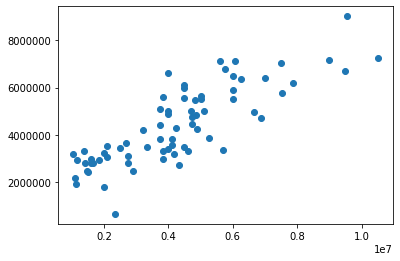

       Residual
0  1.841289e+06
1  1.700181e+06
2  1.742431e+06
3  1.735714e+06
4  1.837444e+06
50
1000
1538082.3704216299
95.0 confidence interval 1538082.4 and 1903446.9
Dtree


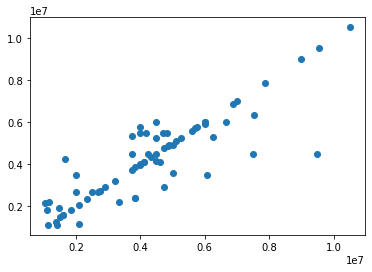

       Residual
0  2.060251e+06
1  2.012121e+06
2  2.317083e+06
3  2.126713e+06
4  1.862732e+06
50
1000
1797356.6857072085
95.0 confidence interval 1797356.7 and 2343865.3
SVR


   Residual
0  0.000628
1  0.000310
2  0.000894
3  0.000607
4  0.000650
50
1000
0.0003380121759396707
95.0 confidence interval 0.0 and 0.0
SGD


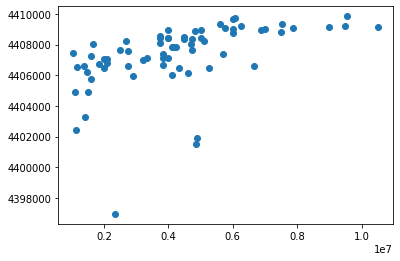

       Residual
0   2663.663690
1  29016.687203
2  34388.023906
3   4506.455669
4   7385.206388
50
1000
1798.8610152722047
95.0 confidence interval 1798.9 and 38022.0
Bagging


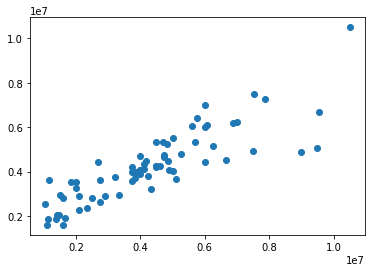

       Residual
0  1.670671e+06
1  1.721651e+06
2  1.727292e+06
3  1.722062e+06
4  1.664244e+06
50
1000
1435251.5938958193
95.0 confidence interval 1435251.6 and 1853917.4


In [14]:
reg = Lasso()
dtree=DecisionTreeRegressor(criterion='mse')
svr = SVR(kernel='rbf')
sgd=SGDRegressor(max_iter=1000, tol=1e-3)
model = BaggingRegressor()

warnings.filterwarnings("ignore")

print("Lasso")
alphaREGS,lowerREGS,upperREGS=bs(reg,modelSeason18X,y)
print("Dtree")
alphaDTS,lowerDTS,upperDTS=bs(dtree,modelSeason18X,y)
print("SVR")
alphaSVRS,lowerSVRS,upperSVRS=bs(svr,modelSeason18X,y)
print("SGD")
alphaSGDS,lowerSGDS,upperSGDS=bs(sgd,modelSeason18X,y)
print("Bagging")
alphaBRS,lowerBRS,upperBRS=bs(model,modelSeason18X,y)


In [ ]:
def bsLog(model,xVal,yVal):
    n_iterations = 1000
    n_size = int(len(xVal)*.8)
    # run bootstrap
    stats  = list()
    val_residuals = list()
    for i in range(n_iterations):
        # prepare train and test sets
        samp=resample(range(0,len(xVal)-1), n_samples=n_size)
        xtrain = xVal.loc[samp,:]
        xtest = xVal.loc[set(range(0,len(xVal)-1))-set(samp),:]
        ytrain = yVal.loc[samp]
        ytest = yVal.loc[set(range(0,len(xVal)-1))-set(samp)]
        xtrain=xtrain.reset_index(drop=True)
        xtest=xtest.reset_index(drop=True)
        ytrain=ytrain.reset_index(drop=True)
        ytest=ytest.reset_index(drop=True)
        
        # fit model
        #model = DecisionTreeClassifier()
        model.fit(xtrain, ytrain)
        # evaluate model
        predictions = model.predict(xtest)
        #print( [i ** 2 for i in (ytest - predictions)])
        #print((ytest - predictions)^2)
        #print([sum((j ** 2))/(len(xtest)-2) for j in (ytest - predictions)])
        val_residuals.append(np.std(np.exp(model.predict(X_test))))
        score = model.score(xtest, ytest)
        stats.append(score)
        #bootstrap_preds[i] = predictions
    
    #bootstrap_preds -= np.mean(bootstrap_preds)
    #val_residuals = np.concatenate(val_residuals)
    
    #fix######################################################################
    plt.scatter(np.exp((y_test)),np.exp(model.predict(X_test)))
    plt.show()
    
    val_residuals=pd.DataFrame(list(val_residuals),columns=['Residual'])
    print(val_residuals.head())
    
    val_residuals.sort_values(by=['Residual'],inplace=True)
    val_residuals=val_residuals.reset_index(drop=True)
    print(int(n_iterations*.05))
    print(len(val_residuals))
    print(val_residuals.iloc[int(n_iterations*.05),0])
    
    # plot scores
    #plt.hist(stats)
    #plt.show()
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f and %.1f' % (alpha*100, np.exp(val_residuals.iloc[int(n_iterations*.05),0]),np.exp(val_residuals.iloc[int(n_iterations*.975),0])))
    
    
    return alpha,np.exp(val_residuals.iloc[int(n_iterations*.05),0]),np.exp(val_residuals.iloc[int(n_iterations*.05),0])



In [ ]:
y=np.log(modelSeason18['Cap Hit'].astype('float64'))

In [ ]:
print("Lasso")
alphaREGS,lowerREGS,upperREGS=bsLog(reg,modelSeason18X,y)
print("Dtree")
alphaDTS,lowerDTS,upperDTS=bsLog(dtree,modelSeason18X,y)
print("SVR")
alphaSVRS,lowerSVRS,upperSVRS=bsLog(svr,modelSeason18X,y)
print("SGD")
alphaSGDS,lowerSGDS,upperSGDS=bsLog(sgd,modelSeason18X,y)
print("Bagging")
alphaBRS,lowerBRS,upperBRS=bsLog(model,modelSeason18X,y)

In [ ]:
def bsxgb(model,xtrain,ytrain,xtest,ytest):
    n_iterations = 10000
    n_size = int(len(data) * 0.80)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = numpy.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
        #model = DecisionTreeClassifier()
        model.fit(xtrain, ytrain)
        # evaluate model
        predictions = model.predict()
        score = accuracy_score(xtest, ytest)
        print(score)
        stats.append(score)
    
    #fix######################################################################
    plt.scatter(y_test,reg.predict(X_test))
    
    
    
    
    # plot scores
    pyplot.hist(stats)
    pyplot.show()
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, numpy.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, numpy.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [ ]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [ ]:
def bspca(model,xtrain,ytrain,xtest,ytest):
    n_iterations = 10000
    n_size = int(len(data) * 0.80)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = numpy.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
        #model = DecisionTreeClassifier()
        model.fit(xtrain, ytrain)
        # evaluate model
        predictions = model.predict()
        score = accuracy_score(xtest, ytest)
        print(score)
        stats.append(score)
    
    #fix######################################################################
    plt.scatter(y_test,reg.predict(X_test))
    
    
    
    
    # plot scores
    pyplot.hist(stats)
    pyplot.show()
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, numpy.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, numpy.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [ ]:
pca=PCA(2)

pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)